# Random forests for classification and regression.
## Practical examples in R


Ana Casanueva <ana.casanueva@unican.es> y Joaquín Bedia <bediaj@unican.es>

_12 Dec 2024_

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Bagged-random-forests-for-classification" data-toc-modified-id="Bagged-random-forests-for-classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Bagged random forests for classification</a></span><ul class="toc-item"><li><span><a href="#Example-1:-classification-with-the-iris-dataset" data-toc-modified-id="Example-1:-classification-with-the-iris-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Example 1: classification with the iris dataset</a></span></li><li><span><a href="#Comparison-of-the-Random-forest-against-a-single-tree" data-toc-modified-id="Comparison-of-the-Random-forest-against-a-single-tree-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Comparison of the Random forest against a single tree</a></span></li><li><span><a href="#Out-of-bag-error" data-toc-modified-id="Out-of-bag-error-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Out-of-bag error</a></span></li><li><span><a href="#Example-2:-Classification-with-the-meteo-dataset" data-toc-modified-id="Example-2:-Classification-with-the-meteo-dataset-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Example 2: Classification with the <code>meteo</code> dataset</a></span></li><li><span><a href="#Fitting-the-optimum-number-of-predictors-(mtry-parameter):" data-toc-modified-id="Fitting-the-optimum-number-of-predictors-(mtry-parameter):-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Fitting the optimum number of predictors (<code>mtry</code> parameter):</a></span></li></ul></li><li><span><a href="#Bagged-Random-forests-for-regression" data-toc-modified-id="Bagged-Random-forests-for-regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Bagged Random forests for regression</a></span><ul class="toc-item"><li><span><a href="#Example-3:-regression-with-the-Boston-dataset" data-toc-modified-id="Example-3:-regression-with-the-Boston-dataset-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Example 3: regression with the Boston dataset</a></span></li></ul></li><li><span><a href="#Boosted-trees.-Adabag-method" data-toc-modified-id="Boosted-trees.-Adabag-method-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Boosted trees. Adabag method</a></span><ul class="toc-item"><li><span><a href="#Example-4:-Boosted-trees-for-classification-with-the-meteo-dataset" data-toc-modified-id="Example-4:-Boosted-trees-for-classification-with-the-meteo-dataset-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Example 4: Boosted trees for classification with the <code>meteo</code> dataset</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>References</a></span></li><li><span><a href="#Session-info" data-toc-modified-id="Session-info-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Session info</a></span></li></ul></div>

## Bagged random forests for classification

In this first part we get familiar with the `randomForest` package (Liaw and Wiener 2002) and the main components of a random forest object in R.

In [24]:
if (!require("randomForest")) {
    install.packages("randomForest")
} else {
    library("randomForest")
}

### Example 1: classification with the iris dataset

In [25]:
data(iris)

Dataset split for training and testing. The classical 70-30% partition is done:

In [26]:
n <- nrow(iris)
set.seed(1)
indtrain <- sample(1:n, round(0.7*n))  # indices for train
indtest <- setdiff(1:n, indtrain)  # indices for test

In [27]:
rf <- randomForest(Species ~., iris , subset = indtrain)


***

**Exploring the RF object structure. Questions:**
1. How many trees form the random forest?
2. How many predictors are sampled to grow each tree at each split?
3. How many samples are drawn to grow each tree?
4. Can you provide an indication of the relative importance of each explanatory variable?
5. How is variable importance measured?

***

In [28]:
## 1.How many trees form the random forest?
rf$ntree

[1] 500

In [29]:
## 2. How many predictors are sampled to grow each tree at each split?
rf$mtry

[1] 2

In [30]:
## 3. How many samples are drawn to grow each tree?
## This can be seen looking at the default call to the function in the help menu <help("randomForest")> considering the default value of the 'sampsize' argument
# sampsize = if (replace) nrow(x) else ceiling(.632*nrow(x))
# Therefore, the number of samples taken in this case (replacement = TRUE), is
length(indtrain)



[1] 105

In [31]:
## 4. Can you provide an indication of the relative importance of each explanatory variable?
rf$importance

,MeanDecreaseGini
Sepal.Length,7.061638
Sepal.Width,1.896055
Petal.Length,31.783199
Petal.Width,28.418593


In [32]:
## 5. How is variable importance measured?

# The randomForest::importance help provides a description of the variable importance estimation procedure

# Variable importance is measured in this case (classification) using the mean decrease in Gini index (it measures group impurity).
# The greater the decrease, the more important is the variable for improving the classifier performance.

# For each individual tree, the prediction error on the out-of-bag portion of the data is recorded (error rate for classification, MSE for regression).
# Then the same is done after permuting each predictor variable. The difference between the two are then averaged over all trees,
# and normalized by the standard deviation of the differences. If the standard deviation of the differences is
# equal to 0 for a variable, the division is not done (but the average is almost always equal to 0 in that case).

# The second measure is the total decrease in node impurities from splitting on the variable, averaged
# over all trees. For classification, the node impurity is measured by the Gini index. For regression, it
# is measured by residual sum of squares.




Next, the accuracy of the random forest classifier is calculated:

In [33]:
pred <- predict(rf, iris[indtest, ])
(accuracy <- sum(diag(table(pred, iris$Species[indtest]))) / length(indtest))

[1] 0.9555556

### Comparison of the Random forest against a single tree

In [34]:
library(tree)
myTree <- tree(Species ~., iris, subset = indtrain)
# prediction for test
pred.t <- predict(myTree, iris[indtest, ], type = "class")
accuracy.tree <- sum(diag(table(pred.t, iris$Species[indtest]))) / length(indtest)
accuracy.tree

[1] 0.9111111

Using exactly the same data, the Random Forest yields higher predictive accuracy

### Out-of-bag error

For each bootstrap sample taken from the training data, there will be samples left behind that were not included. These samples are called Out-Of-Bag samples (OOB). When averaged over all trees, the predictive performance on OOB samples provides a good estimate of the test error that may be expected.

The study of error estimates for bagged classifiers in [Breiman 1996](https://www.stat.berkeley.edu/~breiman/OOBestimation.pdf), gives empirical evidence to show that the out-of-bag estimate is as accurate as using a test set of the same size as the training set. Therefore, using the out-of-bag error estimate can be as useful as a sepparate test set for model assessment purposes.


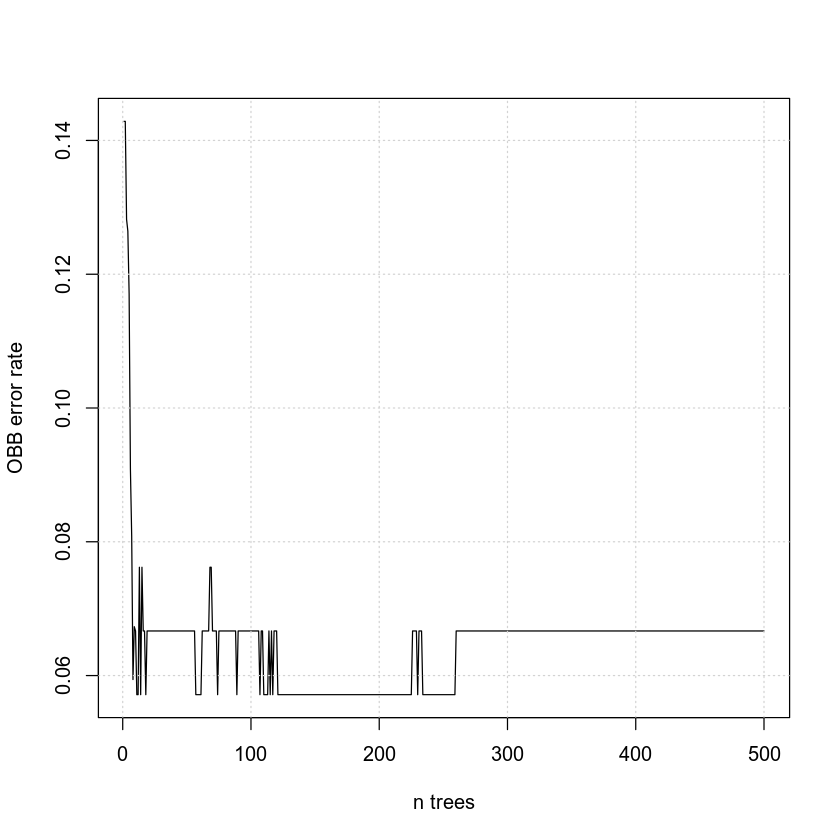

In [35]:
plot(rf$err.rate[, 1], type = "l", xlab = "n trees", ylab = "OBB error rate")
grid()

***
**Questions** 

5. From the OOB error plot above, how many trees would you use for the random forest?
    
***

The minimum OOB error is attained approx around a 125-tree forest. This error then slightly increases and stabilizes, and therefore `ntree=125` seems here a sensible choice. 

Besides, looking into the error rates in more detail, it is possible to ascertain its different components:

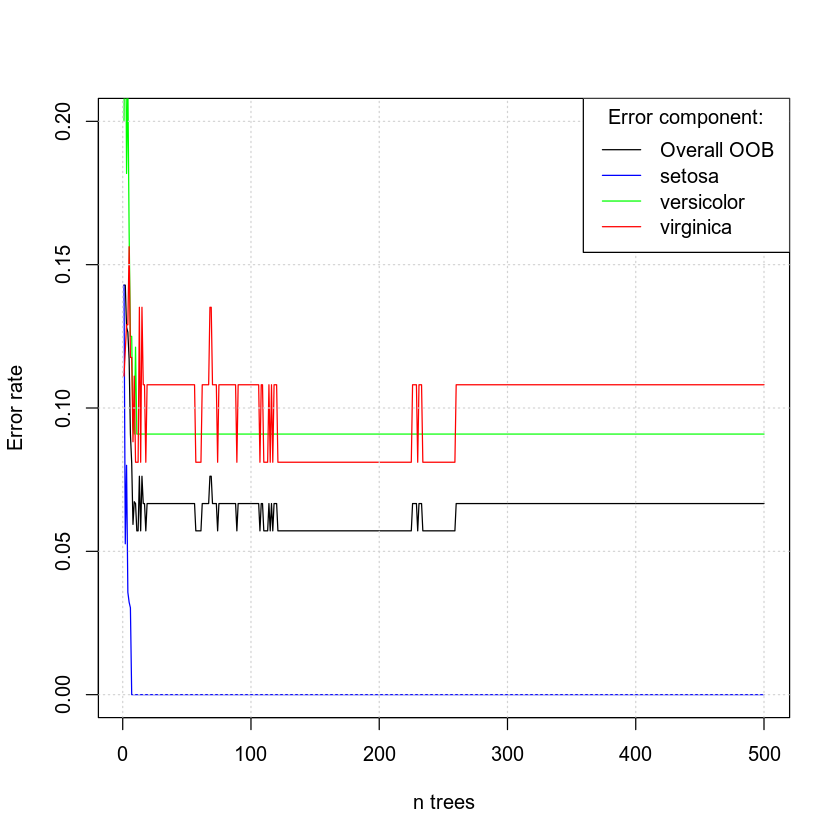

In [36]:
plot(rf$err.rate[, 1], type = "l", xlab = "n trees", ylab = "Error rate",ylim=c(0,0.2))
lines(rf$err.rate[,2], col = "blue")
lines(rf$err.rate[,3], col = "green")
lines(rf$err.rate[,4], col = "red")
grid()
legend("topright", title="Error component:", c("Overall OOB", "setosa", "versicolor", "virginica"), lty = 1, col = c("black", "blue", "green", "red"))

There are other parameters that have an important effect on the resulting predictive ability of the random forest. Three important ones are the number of trees forming the forest (argument `ntree`, as already seen), the number of samples taken in the bootstrapping procedure (`sampsize`) and the number of variables included as predictors in each bootstrap iteration (`mtree`). An example on how to decide suitable parameter values is shown in the next section.

### Example 2: Classification with the `meteo` dataset

Here, we will use the `meteo` dataset. The first column of the `meteo` dataset is the predictand (daily precipitation amount, in mm), and the rest of columns are the predictors, in blocks of 40 neighbouring locations corresponding to 8 different predictors. It contains a continuous record of 10958 days. For convenience, the data are next divided into predictand (first column) and predictors, and reduced to a subset of 1000 days to speed-up calculations. Furthermore, precipitation amount is converted to the binary variables rain/no rain for classification, considering a precipitation threshold of 1 mm. Afterwards, a new dataset is created:

In [37]:
meteo <- read.table("~/DOCENCIA/2024_2025/M1966/datasets/meteo.csv", header = TRUE, sep = ",", row.names = 1)

In [38]:
n <- 1000
y <- meteo[1:n, 1]  ## Predictando
x <- meteo[1:n, -1]  ## Predictores

# binary occurrence (1/0)
occ <- y
occ[which(y < 1)] <- 0
occ[which(y >= 1)] <- 1

# Occurrence dataset:
df.occ <- data.frame(y.bin = as.factor(occ), predictors = x)

The dataset is split into train and test subsets:

In [39]:
set.seed(1)
indtrain <- sample(1:n, round(0.75*n))  # indices for train
indtest <- setdiff(1:n, indtrain)  # indices for test

The first model is constructed using all the default parameters. We set a seed for reproducibility (note that the boostrapping procedure entails a random sampling).

In [40]:
set.seed(123)
rf <- randomForest(y.bin ~., df.occ, subset = indtrain)

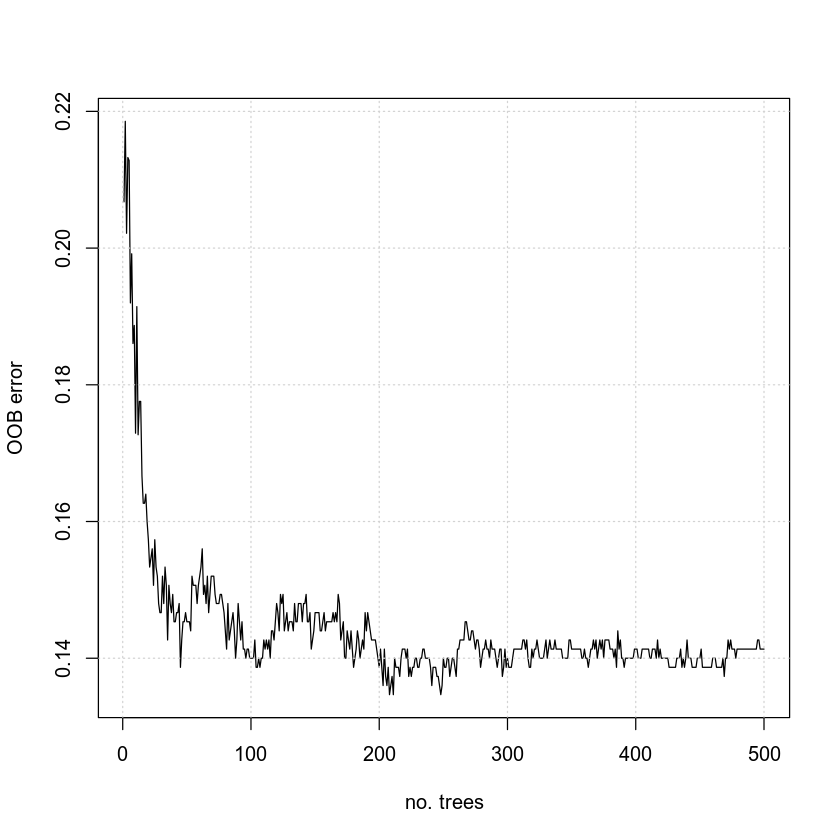

In [41]:
plot(rf$err.rate[, 1], type = "l", xlab = "no. trees", ylab = "OOB error")
grid()

In [42]:
pred <- predict(rf, df.occ[indtest, ])
(accuracy.rf <- sum(diag(table(pred, df.occ$y.bin[indtest]))) / length(indtest))  # error (1-accuracy)

[1] 0.916

It seems that with less trees a low error is attained:

In [43]:
# Optimal number of trees is that minimizing the OOB error:
(ntree.optim <- which.min(rf$err.rate[, 1]))

[1] 208

### Fitting the optimum number of predictors (`mtry` parameter): 

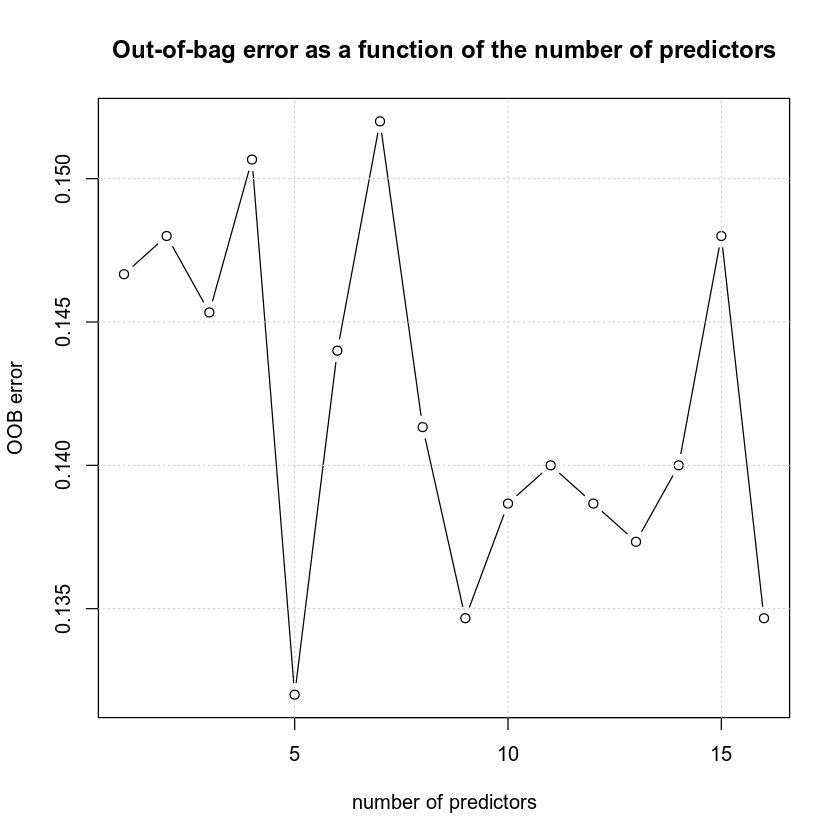

In [44]:
# We search for the `mtry` value attaining minimum error:
mtry.choices <- 2:17 # From 2 to 17 predictors
err <- vector("numeric", length(mtry.choices))
for (i in 1:length(mtry.choices)) {
    set.seed(123)
    rf1 <- randomForest(y.bin ~., df.occ, subset = indtrain, ntree = ntree.optim, mtry = mtry.choices[i])
    pred1 <- predict(rf1, df.occ[indtest, ])
    err[i] <- rf1$err.rate[ntree.optim, 1]
}
plot(err, ty = "b", ylab = "OOB error", xlab = "number of predictors")
grid()
title(main = "Out-of-bag error as a function of the number of predictors")


In [45]:
## results for optimum RF
mtry.best <- which.min(err)  # minimum OOB error
rf.best <- randomForest(y.bin ~., df.occ, subset = indtrain, ntree = ntree.optim, mtry = mtry.best)

The OOB error in this case:

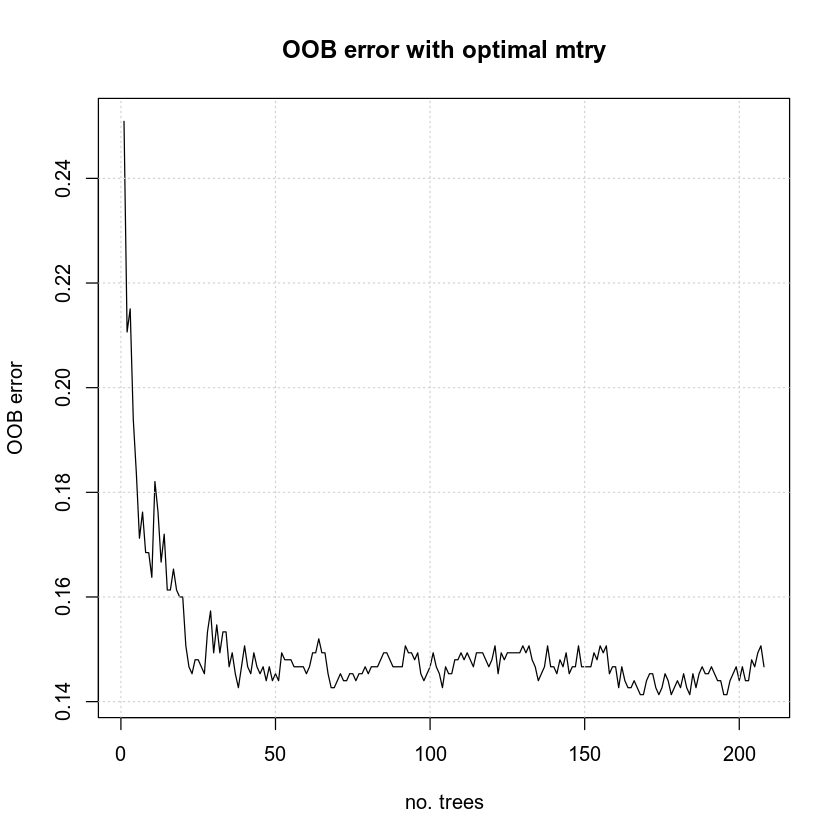

In [46]:
plot(rf.best$err.rate[, 1], type = "l", xlab = "no. trees", ylab = "OOB error", main = "OOB error with optimal mtry")
grid()

In [47]:
(ntree.new <- which.min(rf.best$err.rate[, 1]))

[1] 168

In this example, we have found an optimum value for the number of predictors `mtry`= {{mtry.best}}.
Furthermore, the optimal value of trees for this new `mtry` value is reduced to `ntree`= {{ntree.new}}

***

**Tuning the RF parameters. Questions:**

1. Following the example above, can you provide an optimal value for the bootstrapping sample size (`sampsize`) parameter?

2. Build a new random forest with all the estimated "optimal" parameters, providing a performance assessment (error rates and accuracy).

3. Compare the classification accuracy of this random forest with the random forest that uses default parameters, and alternative choices with differente parameter values. Is it possible to see a significant improvement after having determined the best parameter values?

***

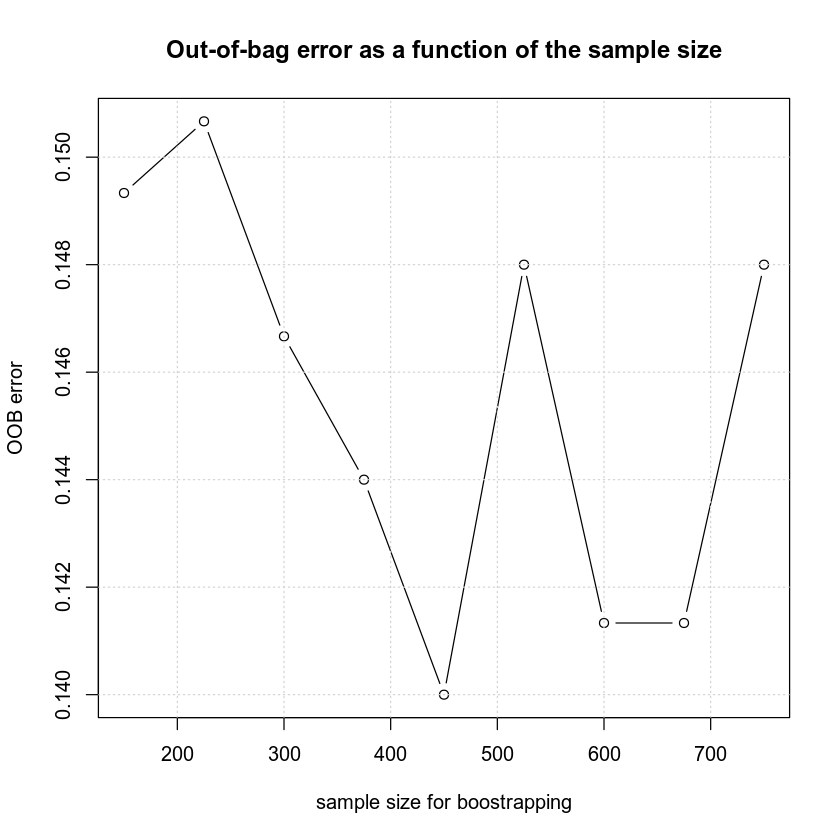

In [48]:
# Next, we search for the `samplesize` value attaining minimum error:
# We consider the updated best number of trees (`ntree.new`)

sampsize.choices <- length(indtrain)*seq(0.2,1,0.1)
err <- vector("numeric", length(sampsize.choices))
for (i in 1:length(sampsize.choices)) {
    set.seed(1)
    rf1 <- randomForest(y.bin ~., df.occ, subset = indtrain,
                        sampsize = sampsize.choices[i],
                        ntree = ntree.new,
                        mtry = mtry.best)
    pred1 <- predict(rf1, df.occ[indtest, ])
    err[i] <- rf1$err.rate[ntree.new, 1]
}
plot(sampsize.choices, err, ty = "b", ylab = "OOB error", xlab = "sample size for boostrapping")
grid()
title(main = "Out-of-bag error as a function of the sample size")


In [49]:
(best.sampsize <- sampsize.choices[which.min(err)])

[1] 450

The optimal sample size is {{best.sampsize}}. Next, we look at the new OOB error with this new model:

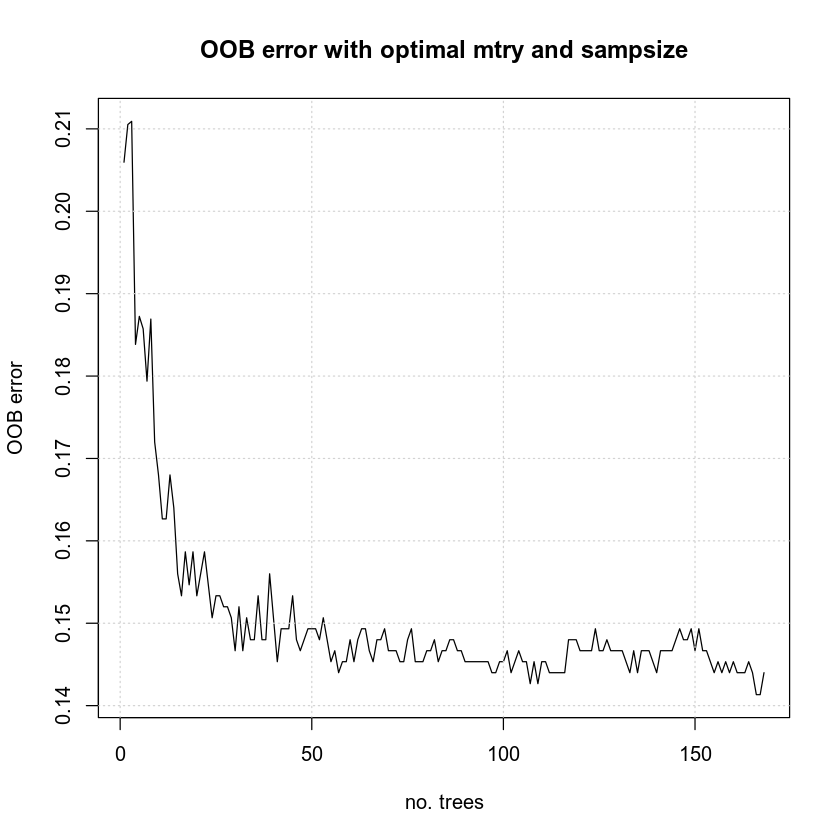

In [50]:
rf.best.new <- randomForest(y.bin ~., df.occ, subset = indtrain, ntree = ntree.new,
                            mtry = mtry.best, sampsize = best.sampsize)
plot(rf.best.new$err.rate[, 1], type = "l",
     xlab = "no. trees",
     ylab = "OOB error",
     main = "OOB error with optimal mtry and sampsize")
grid()

In this case, we keep the current number of trees

In [51]:
set.seed(123)
rf.optim <- randomForest(y.bin ~., df.occ, subset = indtrain,
                         sampsize = best.sampsize,
                         ntree = ntree.new, mtry = mtry.best)

In [52]:
pred <- predict(rf.optim, df.occ[indtest, ])
(acc.best <- sum(diag(table(pred, df.occ$y.bin[indtest]))) / length(indtest))

[1] 0.9

The accuracy achieved by the optimized random forest is {{acc.best}}. This is similar to the accuracy obtained by the raw random forest model ({{accuracy.rf}}), although in this case the model is much simpler, using less trees, less random predictors and a smaller sample size in the bootstrapping.

## Bagged Random forests for regression

### Example 3: regression with the Boston dataset

In [53]:
library(MASS)
n <- nrow(Boston) # train/test partition
indtrain <- sample(1:n, round(0.75*n))  # indices for train
indtest <- setdiff(1:n, indtrain) # indices for test

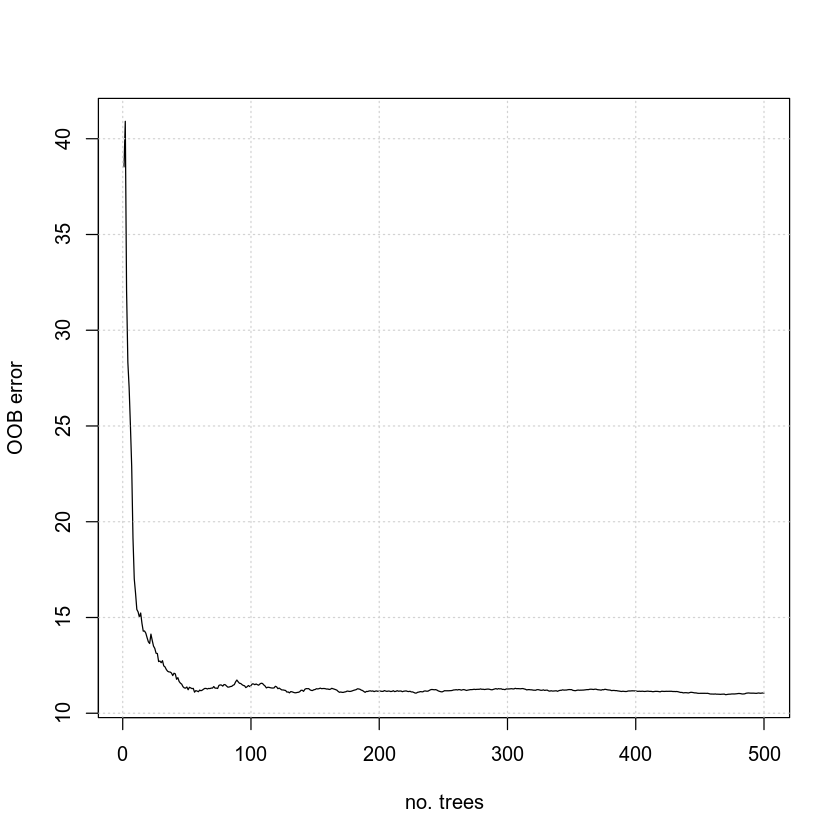

In [54]:
set.seed(1)
rf <- randomForest(medv ~., Boston , subset = indtrain)
plot(rf$mse, type = "l", xlab = "no. trees", ylab = "OOB error")
grid()

***

**Questions**:

1. What is the measure of OOB error in the regression forest?
2. Build a random forest for regression optimizing the number of predictors for tree construction
3. Build a plot displaying the relative importance of each predictor
4. How is here variable importance measured?

***

In regression random forests, the error measure is based on the mean square errors. This is the sum of squared residuals divided by `n`.

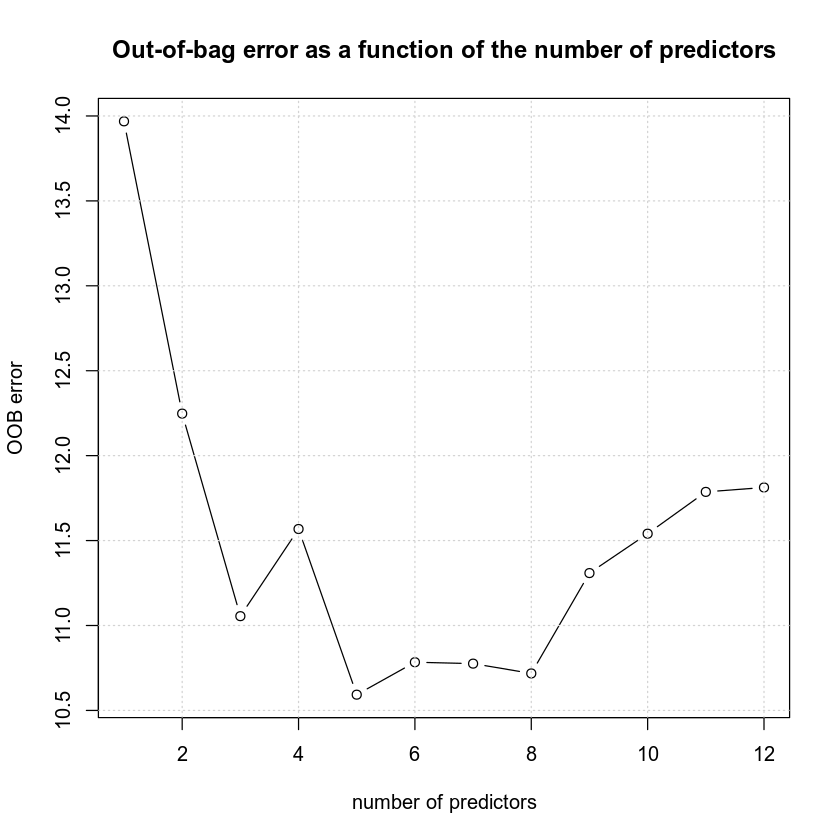

In [55]:
# Optimization of predictor number
# Default ntree = 500 is maintained

mtry.vec <- 2:(ncol(Boston)-1)
err <- vector("numeric", length(mtry.vec))
for (i in 1:length(mtry.vec)) {
    set.seed(1)
    rf1 <- randomForest(medv ~., Boston, subset = indtrain, mtry = mtry.vec[i])
    # pred1 <- predict(rf1, Boston[indtest, ])
    err[i] <- tail(rf1$mse, 1)
}
plot(err, ty = "b", ylab = "OOB error", xlab = "number of predictors")
grid()
title(main = "Out-of-bag error as a function of the number of predictors")


In [56]:
(best.mtry <- which.min(err))

[1] 5

There is a clear optimum around 5 predictors. We choose as optimum number predictors `mtry = {{best.mtry}}`. We next choose an optimum sample size value, given the best `mtry` parameter value already found.

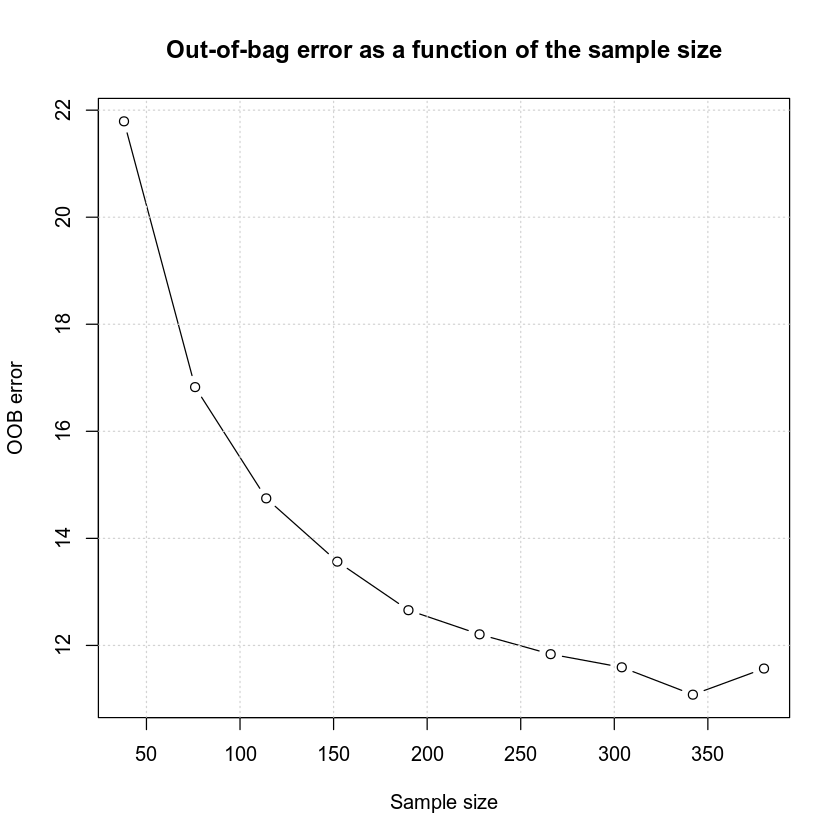

In [57]:
# Optimization of sample size
# Considers an optimal mtry = 4
# Default ntree = 500 is maintained

sampsize.vec <- length(indtrain)*seq(0.1,1,0.1)
err <- vector("numeric", length(sampsize.vec))
for (i in 1:length(sampsize.vec)) {
    set.seed(1)
    rf1 <- randomForest(medv ~., Boston, subset = indtrain,
                        mtry = best.mtry,
                        sampsize = sampsize.vec[i])
    # pred1 <- predict(rf1, Boston[indtest, ])
    err[i] <- tail(rf1$mse, 1)
}
plot(sampsize.vec, err, ty = "b", ylab = "OOB error", xlab = "Sample size")
grid()
title(main = "Out-of-bag error as a function of the sample size")


In this case, the larger the sample, the lower the OOB error. Therefore, we use the number of rows of the training dataset as sampling size in the boostrapping. Note that this is the default behaviour of the `randomForest` function. Finally, we look a the OOB error as a function of the number of trees, in case it is possible to reduce this parameter:

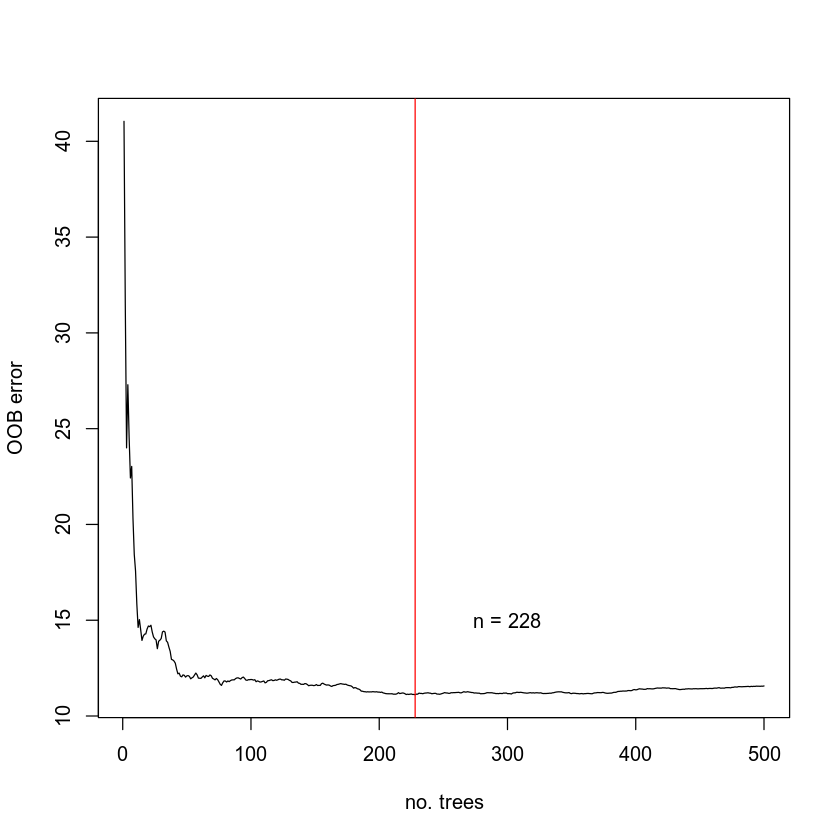

In [58]:
set.seed(1)
rf <- randomForest(medv ~., Boston , subset = indtrain, mtry = best.mtry)
plot(rf$mse, type = "l", xlab = "no. trees", ylab = "OOB error")
best.ntree <- which.min(rf$mse)
abline(v = best.ntree, col = "red")
text(300, 15, paste("n =", best.ntree))

As a result, {{best.ntree}} trees (instead of the default 500) will suffice to construct a random forest with no significant loss of predictive accuracy.

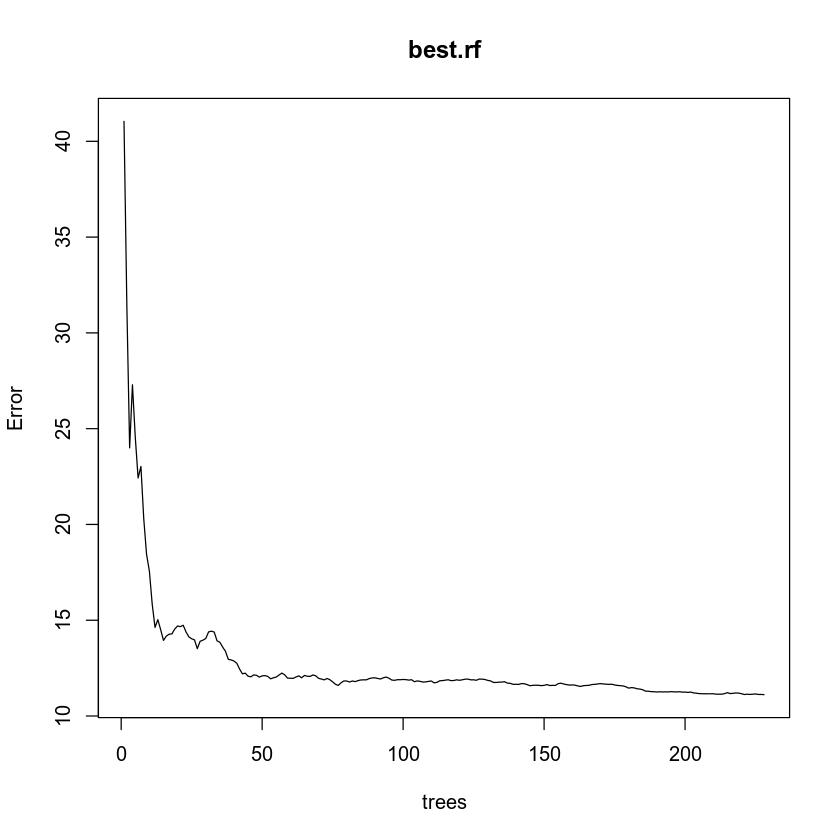

In [59]:
set.seed(1)
best.rf <- randomForest(medv ~., Boston , subset = indtrain, mtry = best.mtry, ntree = best.ntree)
plot(best.rf)

Next, variable importance is assessed:

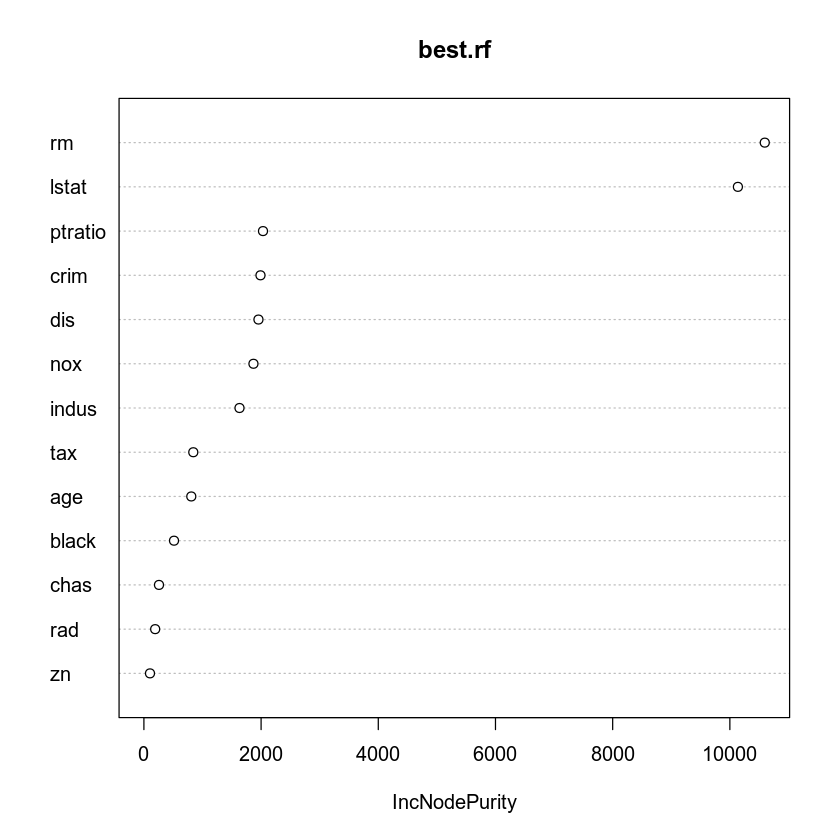

In [60]:
varImpPlot(best.rf)

In this case, variable importance is measured as the mean decrease in MSE produced after the introduction of each variable. The larger the value, the more explanatory power has the variable. `rm` (average number of rooms per dwelling) and `lstat` (lower status of the population -percent-) are here the most important variables to explain the predictand, `medv` (median value of owner-occupied homes).

## Random forests as a missing data filling tool

Random forests can be used for the _imputation_ of missing values. To this aim, the model will perform predictions trained with complete data (i.e. a subset of the original dataset with no missing values) and will assign (impute) the closest values to the missing registers, using as a measure of distance the proximity of other complete instances (the more often an instance fall within the same leave, the closest is to the given input).

The so called proximity matrix contains the `proximity` (i.e., 1-`distance`) of instances to each other. It is an extremely useful item that can be obtained activating the `proximity=TRUE` flag: 

In [61]:
rf_pm <- randomForest(medv ~., Boston , subset = indtrain, proximity = TRUE)

This is how the proximity matrix looks like:

In [62]:
rf_pm$proximity

,234,188,167,112,254,98,331,132,477,433,⋯,142,111,80,486,189,428,321,76,227,228
234,1.00000000,0.00000000,0.13636364,0.00000000,0.24590164,0.32432432,0.00000000,0.00000000,0.00000000,0.00000000,⋯,0.00000000,0.00000000,0.00000000,0.00000000,0.02898551,0.00000000,0.00000000,0.00000000,0.61290323,0.09859155
188,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,⋯,0.00000000,0.00000000,0.00000000,0.00000000,0.19117647,0.00000000,0.02469136,0.01470588,0.00000000,0.03030303
167,0.13636364,0.00000000,1.00000000,0.01369863,0.02777778,0.03947368,0.00000000,0.00000000,0.00000000,0.00000000,⋯,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.13888889,0.01470588
112,0.00000000,0.00000000,0.01369863,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.01351351,0.00000000,⋯,0.00000000,0.01818182,0.00000000,0.00000000,0.00000000,0.00000000,0.01515152,0.01562500,0.00000000,0.00000000
254,0.24590164,0.00000000,0.02777778,0.00000000,1.00000000,0.21875000,0.00000000,0.00000000,0.00000000,0.00000000,⋯,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.18055556,0.00000000
98,0.32432432,0.00000000,0.03947368,0.00000000,0.21875000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,⋯,0.00000000,0.00000000,0.00000000,0.00000000,0.01449275,0.00000000,0.00000000,0.00000000,0.20895522,0.02500000
331,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,⋯,0.00000000,0.00000000,0.03333333,0.00000000,0.05084746,0.00000000,0.00000000,0.14925373,0.00000000,0.00000000
132,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.02857143,0.01562500,⋯,0.02857143,0.01428571,0.00000000,0.05454545,0.00000000,0.01492537,0.00000000,0.00000000,0.00000000,0.00000000
477,0.00000000,0.00000000,0.00000000,0.01351351,0.00000000,0.00000000,0.00000000,0.02857143,1.00000000,0.00000000,⋯,0.05970149,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
433,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.01562500,0.00000000,1.00000000,⋯,0.00000000,0.01886792,0.00000000,0.09090909,0.00000000,0.15384615,0.01388889,0.00000000,0.00000000,0.00000000


***
**Questions**:
1. What is the measure of _proximity_ among observations?
2. Can you think of a potential application of this output?
***

Proximity is here the frequency in which each pair of observations falls within the same tree leave in the random forest created. The most often a pair of observations falls together in the same leave, the highest their proximity.

This concept can serve as a technique for unsupervised classification (clustering) of the observations. Next, an example is shown in which the proximity is used as a measure for grouping the observations:

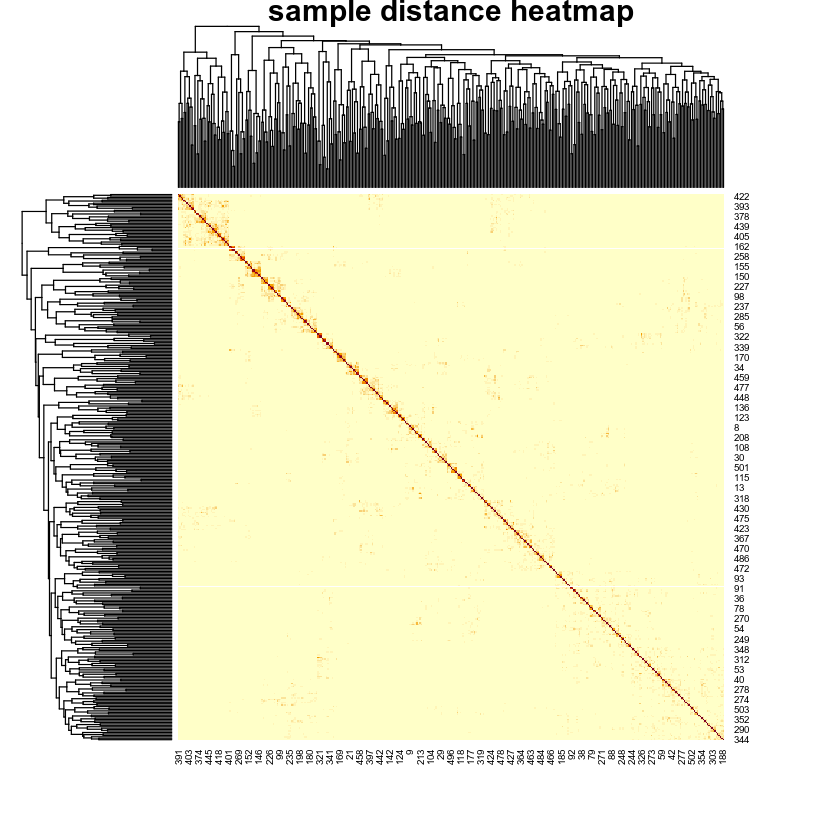

In [63]:
heatmap(x = rf_pm$proximity, symm = TRUE, main = "sample distance heatmap")

The proximity matrix from the `randomForest` is used to update the imputation of the `NAs`. For continuous predictors, the imputed value is the _weighted average_ of the non-missing obervations, where the weights are the proximities. For categorical predictors, the imputed value is the category with the largest average proximity. This process is iterated `iter` times (deafult to 5).

In [64]:
# In this example we artifically generate 25 missing values <NA> of the variable "lstat" in the training dataset:
missing_data_rows <- sample(indtrain, 25)
Boston[missing_data_rows, "lstat"] <- NA
head(Boston[missing_data_rows,])

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
176,0.06664,0,4.05,0,0.510,6.546,33.1,3.1323,5,296,16.6,390.96,NA,29.4
128,0.25915,0,21.89,0,0.624,5.693,96.0,1.7883,4,437,21.2,392.11,NA,16.2
352,0.07950,60,1.69,0,0.411,6.579,35.9,10.7103,4,411,18.3,370.78,NA,24.1
99,0.08187,0,2.89,0,0.445,7.820,36.9,3.4952,2,276,18.0,393.53,NA,43.8
472,4.03841,0,18.10,0,0.532,6.229,90.7,3.0993,24,666,20.2,395.33,NA,19.6
484,2.81838,0,18.10,0,0.532,5.762,40.3,4.0983,24,666,20.2,392.92,NA,21.8


The function `rfImpute`, in package randomForest, performs missing value imputations in predictor data using the proximity matrix from `randomForest` output. 

In [65]:
filled_data <- rfImpute(medv ~., Boston , subset = indtrain)

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |       13    14.79 |
     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |    11.57    13.17 |
     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |     11.8    13.42 |
     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |    11.58    13.17 |
     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |     11.4    12.97 |


We next compare the original deleted data with the data "guessed" by the imputation algorithm based on random forest:

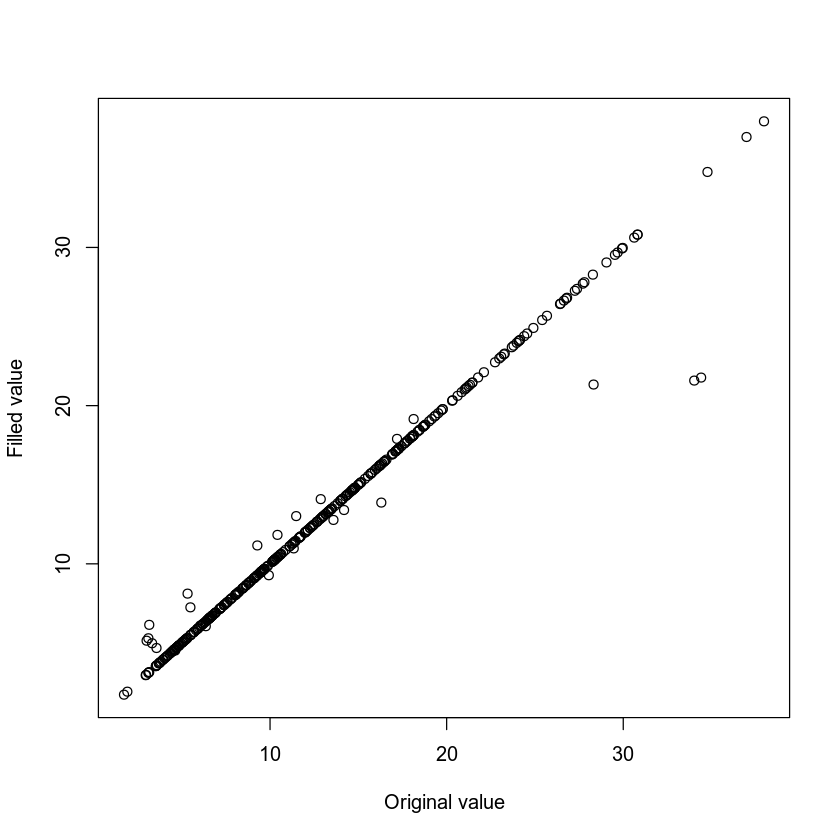

In [66]:
data(Boston)
plot(Boston[indtrain,'lstat'], filled_data$lstat, xlab = "Original value", ylab = "Filled value")

After imputation, all the missing values have been filled, so we get a set of complete data. Filled points exhibit departures from the perfect diagonal, since they are estimated.

Note that the argument `iter` in `rfImpute` allows to perform more iterations, possibly improving the estimation of the imputed values

## Boosted trees. Adabag method

### Example 4: Boosted trees for classification with the `meteo` dataset

We illustrate gradient boosting using the `adabag` package (Alfaro y García 2013). We use the `meteo` dataset again, as previously pre-processed in Example 2. This is a brief example on how to apply adabag, that will be extended during the gradient boosting lab session.

In [67]:
if (!require("adabag")) install.packages("adabag")
library("adabag")

Loading required package: adabag

Loading required package: rpart

Loading required package: caret

Loading required package: lattice

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin


Loading required package: foreach

Loading required package: doParallel

Loading required package: iterators

Loading required package: parallel



In [68]:
ab <- boosting(y.bin ~., df.occ[indtrain, ], mfinal = 20)

The function `errorevol`calculates how the classification/prediction error evolves as the ensemble size grows.

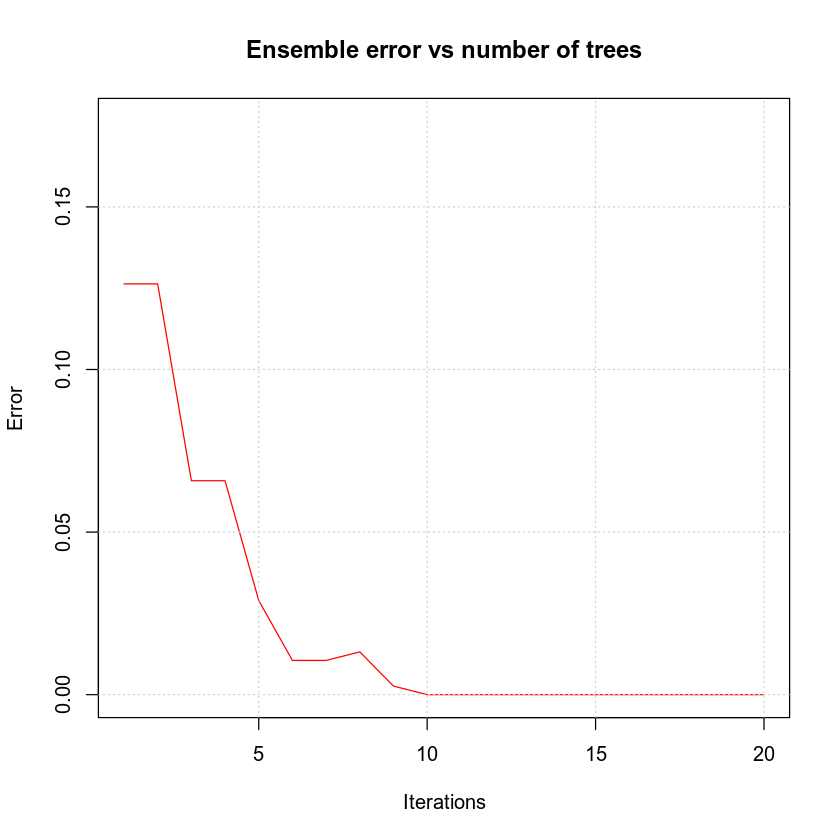

In [69]:
plot(errorevol(ab, df.occ[indtrain, ]))
grid()

It is possible to extract individual trees generated during the boosting procedure to investigate the process:

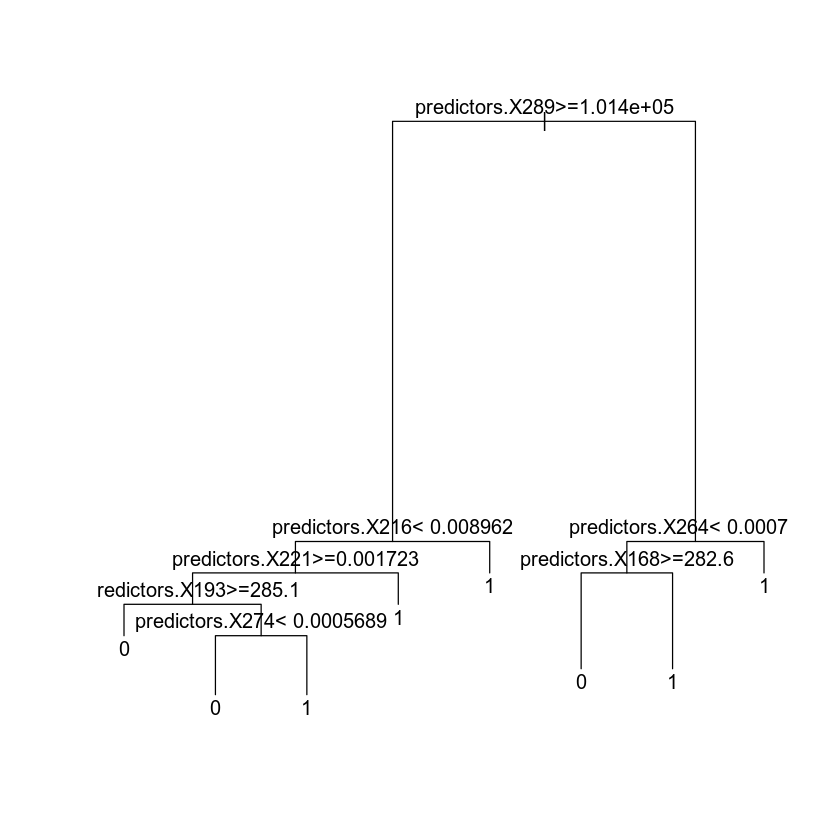

In [70]:
plot(ab$trees[[1]])
text(ab$trees[[1]])

We next depict the sequential tree generation by displaying some intermediate trees from the first to the 20th:

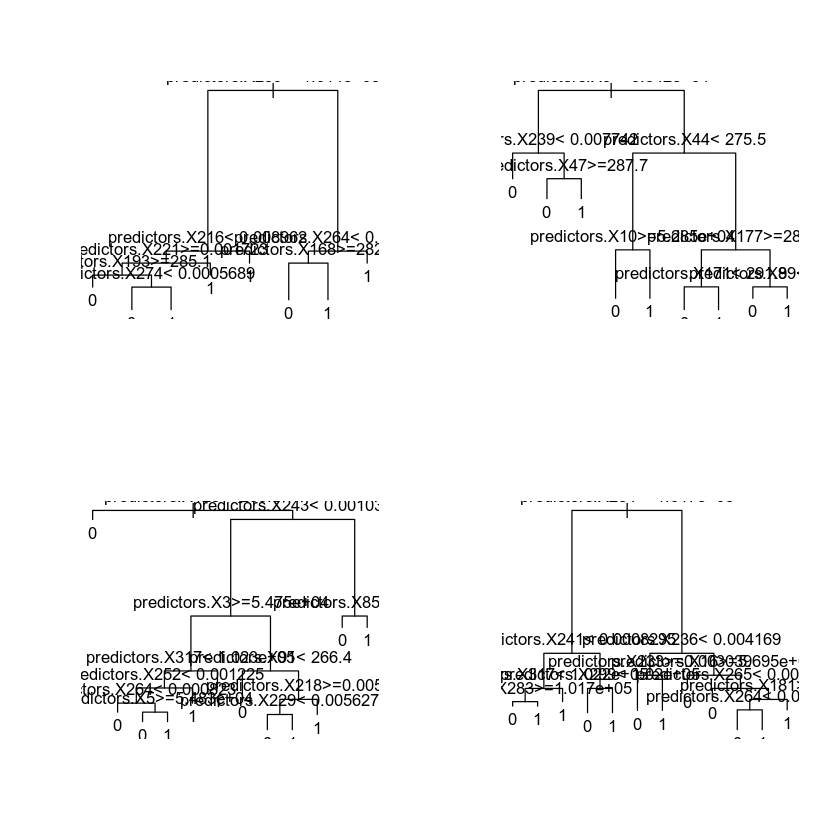

In [71]:
par(mfrow=c(2,2))
for (i in c(1,5,10,20)) {
    plot(ab$trees[[i]])
    text(ab$trees[[i]]) 
}

Finally, we obtain the prediction error (as 1-accuracy):

In [72]:
## prediction for test
pred.ab <- predict(ab, df.occ[indtest, ])
# test error
1 - sum(diag(table(pred.ab$class, df.occ$y.bin[indtest]))) / length(indtest)

[1] 0.1269841

## References

 * Alfaro, E., Gamez, M. Garcia, N.(2013). adabag: An R Package for Classification with Boosting
  and Bagging. Journal of Statistical Software, 54(2), 1-35. URL
  http://www.jstatsoft.org/v54/i02/.
  
 * Liaw, A. and Wiener, M. (2002). Classification and Regression by randomForest. R News 2(3),
  18--22.
  
 * Random forests - classification description [WWW Document], n.d. URL https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#missing1 (accessed 12.20.23).


## Session info

In [73]:
print(sessionInfo())

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/juaco/miniconda3/envs/atlas/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] adabag_4.2          doParallel_1.0.16   iterators_1.0.14   
 [4] foreach_1.5.2       caret_6.0-88        ggplot2_3.3.5      
 [7] lattice_0.20-44     rpart_4.1-15        MASS_7.3-54        
[10] tree_1.0-40         randomForest_4.6-14

loaded via a namespace (and not attached):
 [1] Rcp